# Hierarchical Clustering

The objective of this lab is to become familiar with **hierarchical clustering** and to work with **dendrograms**.

## Imports

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.cluster.hierarchy import dendrogram, cut_tree, linkage
import seaborn as sns

In [3]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix

In [4]:
from sknetwork.data import karate_club, load_netset
from sknetwork.embedding import GSVD
from sknetwork.visualization import svg_graph

## Iris dataset

We start with the Iris dataset.

In [5]:
iris = datasets.load_iris()
X = iris.data  
y = iris.target
feature_names = iris.feature_names
label_names = list(iris.target_names)

In [6]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([50, 50, 50], dtype=int64))

In [7]:
# hierarchical clustering
Z = linkage(X, method='ward')

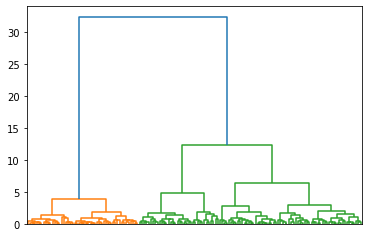

In [8]:
dendrogram(Z, no_labels=True)
plt.show()

## To do

* What are the two first flowers merged? Compare their features.
* Give the 2 first clusters. Show the contingency matrix.
* Give the 3 first clusters. Give the ARI and AMI of the clustering. Compare with K-Means.
* Test other linkages.
* Complete the function ``get_best_cuts`` and select the 2 best cuts of the dendrogram.

In [9]:
y_pred = cut_tree(Z, 2).ravel()

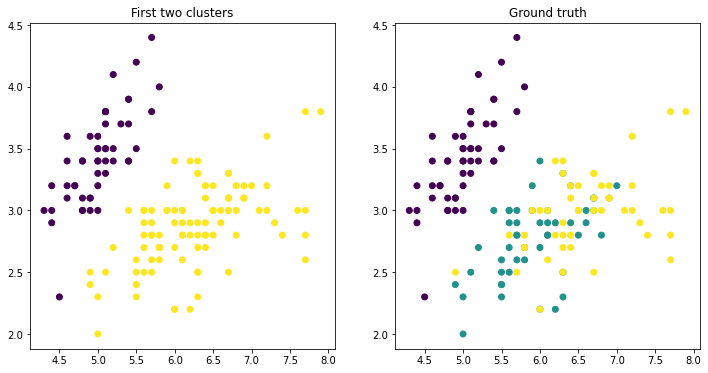

In [10]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(X[:,0], X[:,1], c=y_pred)
ax.set_title("First two clusters")
ax = fig.add_subplot(122)
ax.scatter(X[:,0], X[:,1], c=y)
ax.set_title("Ground truth")
plt.show()

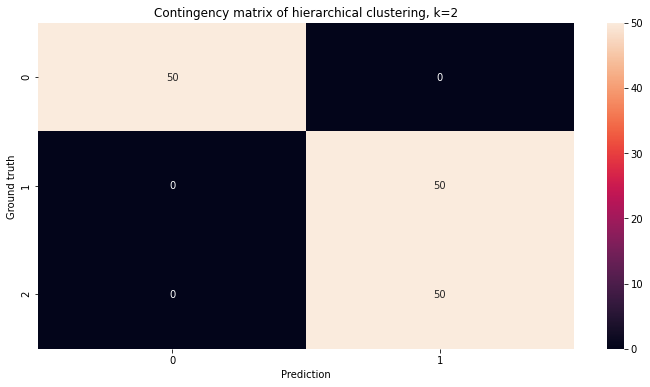

In [11]:
cm = contingency_matrix(y, y_pred)
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True)
plt.ylabel("Ground truth")
plt.xlabel("Prediction")
plt.title("Contingency matrix of hierarchical clustering, k=2")
plt.show()

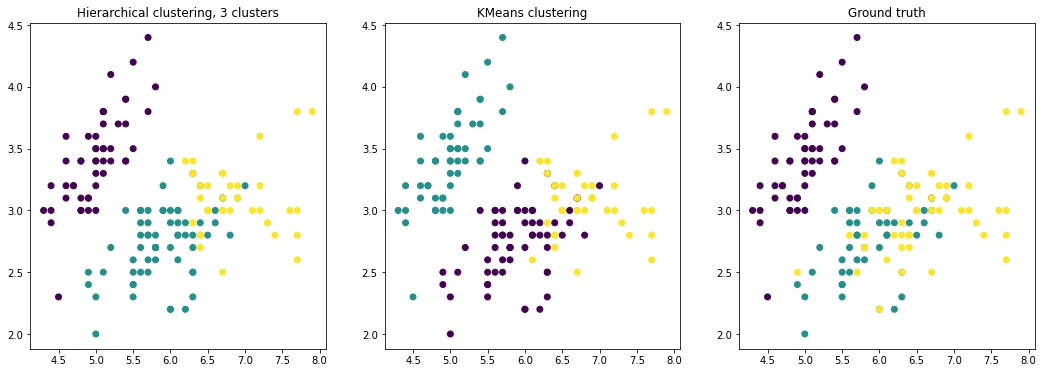

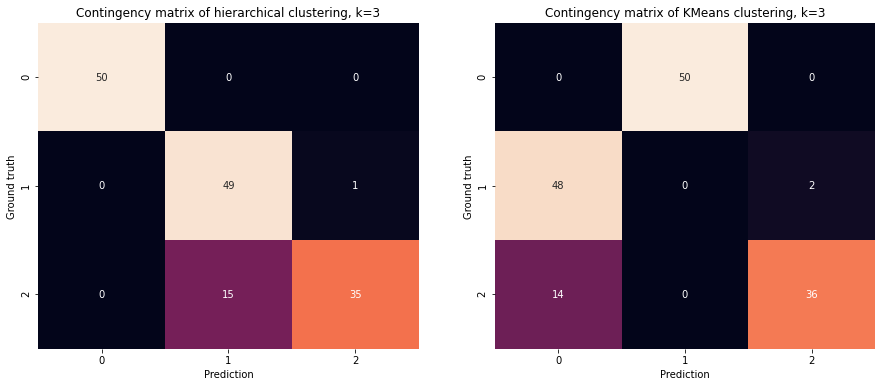

Metrics :
Hierarchical :
ARI : 0.73, AMI : 0.77
KMeans :
ARI : 0.73, AMI : 0.76


In [12]:
y_pred = cut_tree(Z, 3).ravel()
km = KMeans(3)
km.fit(X)
y_pred_km = km.labels_

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(131)
ax.scatter(X[:,0], X[:,1], c=y_pred)
ax.set_title("Hierarchical clustering, 3 clusters")
ax = fig.add_subplot(132)
ax.scatter(X[:,0], X[:,1], c=y_pred_km)
ax.set_title("KMeans clustering")
ax = fig.add_subplot(133)
ax.scatter(X[:,0], X[:,1], c=y)
ax.set_title("Ground truth")
plt.show()

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,6))
cm = contingency_matrix(y, y_pred)
g1 = sns.heatmap(cm, annot=True, cbar=False, ax=ax1)
g1.set_ylabel("Ground truth")
g1.set_xlabel("Prediction")
g1.set_title("Contingency matrix of hierarchical clustering, k=3")
cm = contingency_matrix(y, y_pred_km)
g2 = sns.heatmap(cm, annot=True, cbar=False, ax=ax2)
g2.set_ylabel("Ground truth")
g2.set_xlabel("Prediction")
g2.set_title("Contingency matrix of KMeans clustering, k=3")
plt.show()

print("Metrics :")
print("Hierarchical :")
print(f"ARI : {round(adjusted_rand_score(y,y_pred), 2)}, AMI : {round(adjusted_mutual_info_score(y,y_pred), 2)}")
print("KMeans :")
print(f"ARI : {round(adjusted_rand_score(y,y_pred_km), 2)}, AMI : {round(adjusted_mutual_info_score(y,y_pred_km), 2)}")

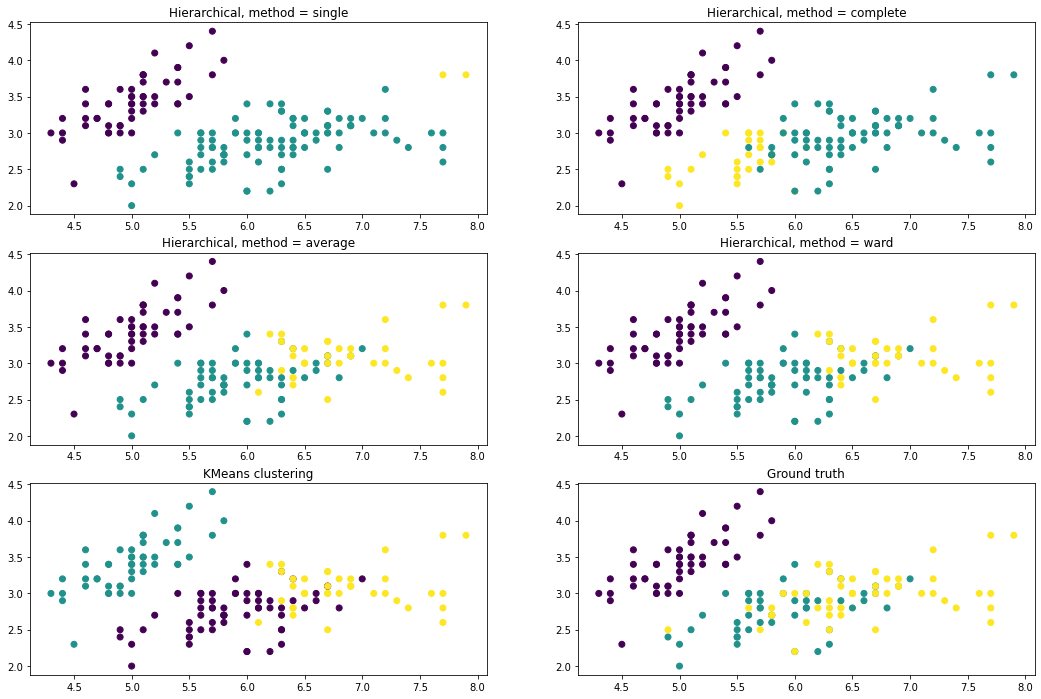

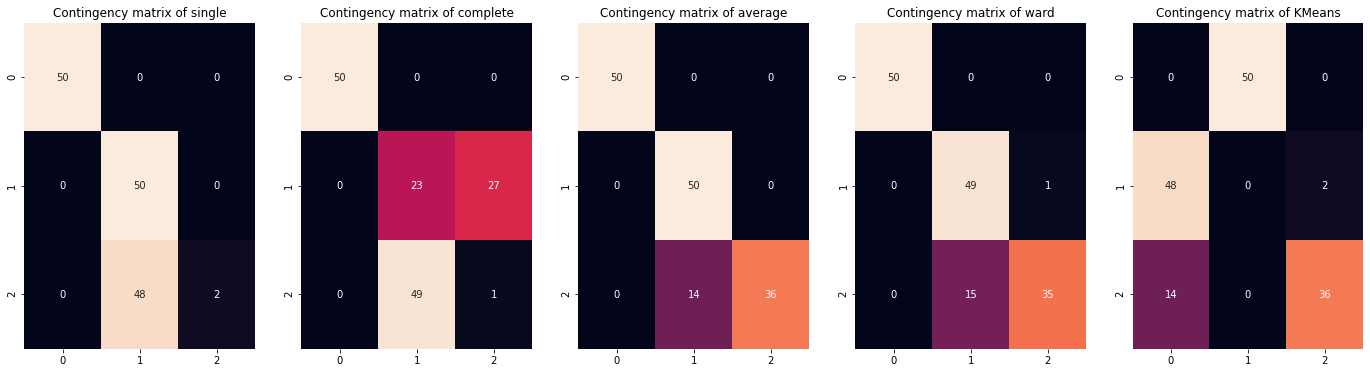

In [13]:
km = KMeans(3)
km.fit(X)
y_pred_km = km.labels_

fig = plt.figure(figsize=(18,12))
for i,method in enumerate(["single","complete","average","ward"]):
    Z = linkage(X, method=method)
    y_pred = cut_tree(Z, 3).ravel()
    ax = fig.add_subplot(3,2,i+1)
    ax.scatter(X[:,0], X[:,1], c=y_pred)
    ax.set_title(f"Hierarchical, method = {method}")
ax = fig.add_subplot(3,2,5)
ax.scatter(X[:,0], X[:,1], c=y_pred_km)
ax.set_title("KMeans clustering")
ax = fig.add_subplot(3,2,6)
ax.scatter(X[:,0], X[:,1], c=y)
ax.set_title("Ground truth")
plt.show()

ARIs = {}
AMIs = {}

f, ax = plt.subplots(1, 5, figsize=(24,6))
for i, method in enumerate(["single","complete","average","ward"]):
    Z = linkage(X, method=method)
    y_pred = cut_tree(Z, 3).ravel()
    cm = contingency_matrix(y, y_pred)
    g1 = sns.heatmap(cm, annot=True, cbar=False, ax=ax[i])
    g1.set_title(f"Contingency matrix of {method}")
    ARIs[method] = adjusted_rand_score(y,y_pred)
    AMIs[method] = adjusted_mutual_info_score(y,y_pred)
cm = contingency_matrix(y, y_pred_km)
g2 = sns.heatmap(cm, annot=True, cbar=False, ax=ax[-1])
g2.set_title("Contingency matrix of KMeans")
plt.show()

ARIs["km"] = adjusted_rand_score(y,y_pred_km)
AMIs["km"] = adjusted_mutual_info_score(y,y_pred_km)

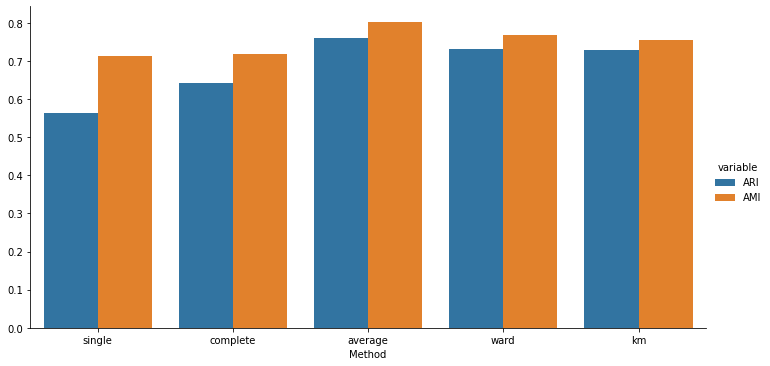

In [14]:
import pandas as pd

df = pd.DataFrame(ARIs, index=["ARI"]).append(pd.DataFrame(AMIs, index=["AMI"]))

sns.catplot(data=df.T.reset_index().melt(id_vars=["index"],value_vars=["ARI","AMI"]),x="index",y="value",hue="variable",kind="bar",aspect=2)
plt.xlabel("Method")
plt.ylabel("")
plt.show()

In [15]:
def get_best_cuts(Z, k_max=10):
    '''Cuts in decreasing order of height gaps. 
    If the best cut is with 2 clusters, the returned vector starts with 2.
    
    Parameters
    ----------
    Z: np.ndarray
        Dendrogram
    k_max: int
        Maximum number of clusters
    Returns
    -------
    cuts: np.ndarray
        Cuts.
    '''
    Zflip = np.flip(Z, 0)
    c = (np.argsort(Zflip[:,2] - np.append(Zflip[1:,2],[0]))[::-1]+2)[(np.argsort(Zflip[:,2] - np.append(Zflip[1:,2],[0]))[::-1]+2) <= k_max]
    return c

In [16]:
get_best_cuts(Z)

array([ 2,  3,  4,  5,  6,  8,  9,  7, 10], dtype=int64)

## Karate Club

We now consider graphs. The Ward method is applied to the embedding of the graph by [GSVD](https://scikit-network.readthedocs.io/en/latest/reference/embedding.html?highlight=GSVD#sknetwork.embedding.GSVD).

In [17]:
graph = karate_club(True)

In [18]:
adjacency = graph.adjacency
labels = graph.labels
position = graph.position

In [19]:
image = svg_graph(adjacency, position, labels=labels)

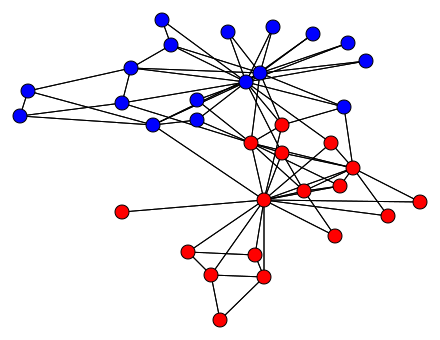

In [20]:
SVG(image)

## To do

* Apply hierarchical clustering to the embedding in dimension 3.
* Display the dendrogram.
* Display the best clustering.
* Compare with the ground-truth using ARI and AMI.

In [21]:
gsvd = GSVD(n_components=3)

In [22]:
X = gsvd.fit_transform(adjacency)

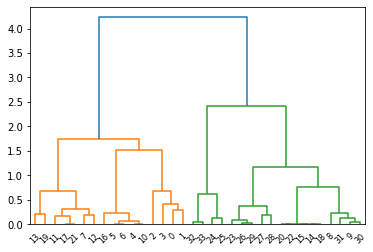

In [23]:
Z = linkage(X, method="ward")

dendrogram(Z)
plt.show()

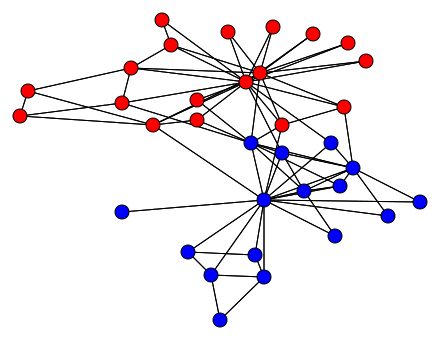

In [24]:
y_pred = cut_tree(Z,get_best_cuts(Z)[0]).ravel()

image = svg_graph(adjacency, position, labels=y_pred)
SVG(image)

In [25]:
print("Metrics :")
print(f"ARI : {round(adjusted_rand_score(labels,y_pred), 2)}, AMI : {round(adjusted_mutual_info_score(labels,y_pred), 2)}")

Metrics :
ARI : 0.88, AMI : 0.83


## Openflights

In [26]:
graph = load_netset('openflights')

Parsing files...
Done.


In [27]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

In [28]:
image = svg_graph(adjacency, position, width=800, height=400, display_node_weight=True, display_edges=False)

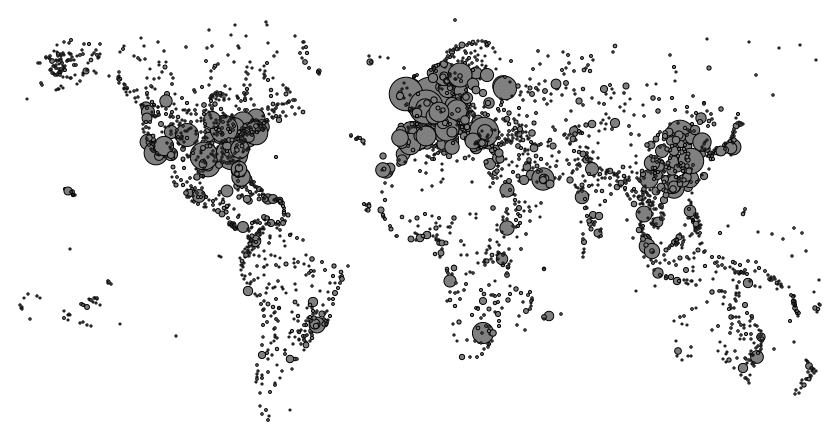

In [29]:
SVG(image)

## To do

* Apply hierarchical clustering to the embedding in dimension 20.
* Select the 2 best clusterings.
* For each of these 2 clusterings, display the graph with the corresponding labels.
* Apply hierarchical clustering to the top-100 airports in terms of traffic (i.e., to the corresponding 100 vectors in the embedding space). Display the dendrogram with the names of these airports. <br>
**Hint:** Check the ``orientation`` parameter of the function ``dendrogram``.

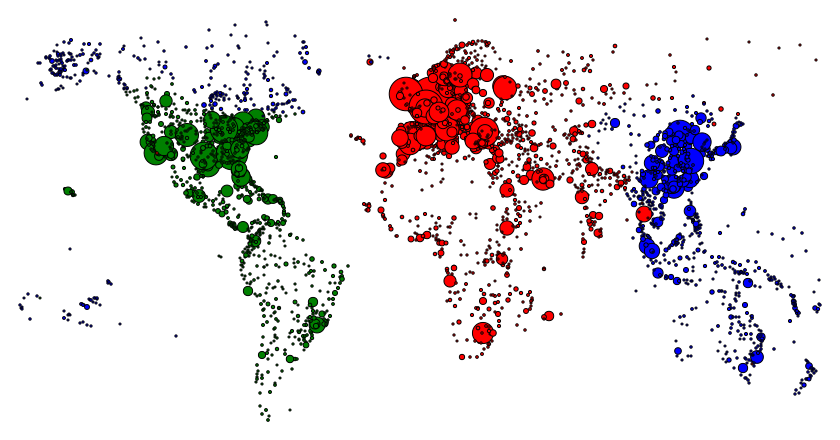

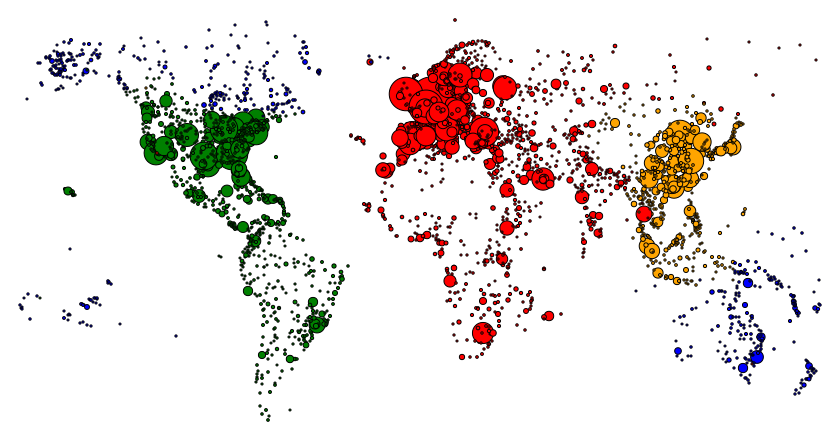

In [30]:
gsvd = GSVD(n_components=20)
X = gsvd.fit_transform(adjacency)
Z = linkage(X, method="ward")

for best_cut in get_best_cuts(Z, len(Z))[:2]:
    image = svg_graph(adjacency, position, width=800, height=400, display_node_weight=True, display_edges=False, labels=cut_tree(Z, best_cut).ravel())
    display(SVG(image))

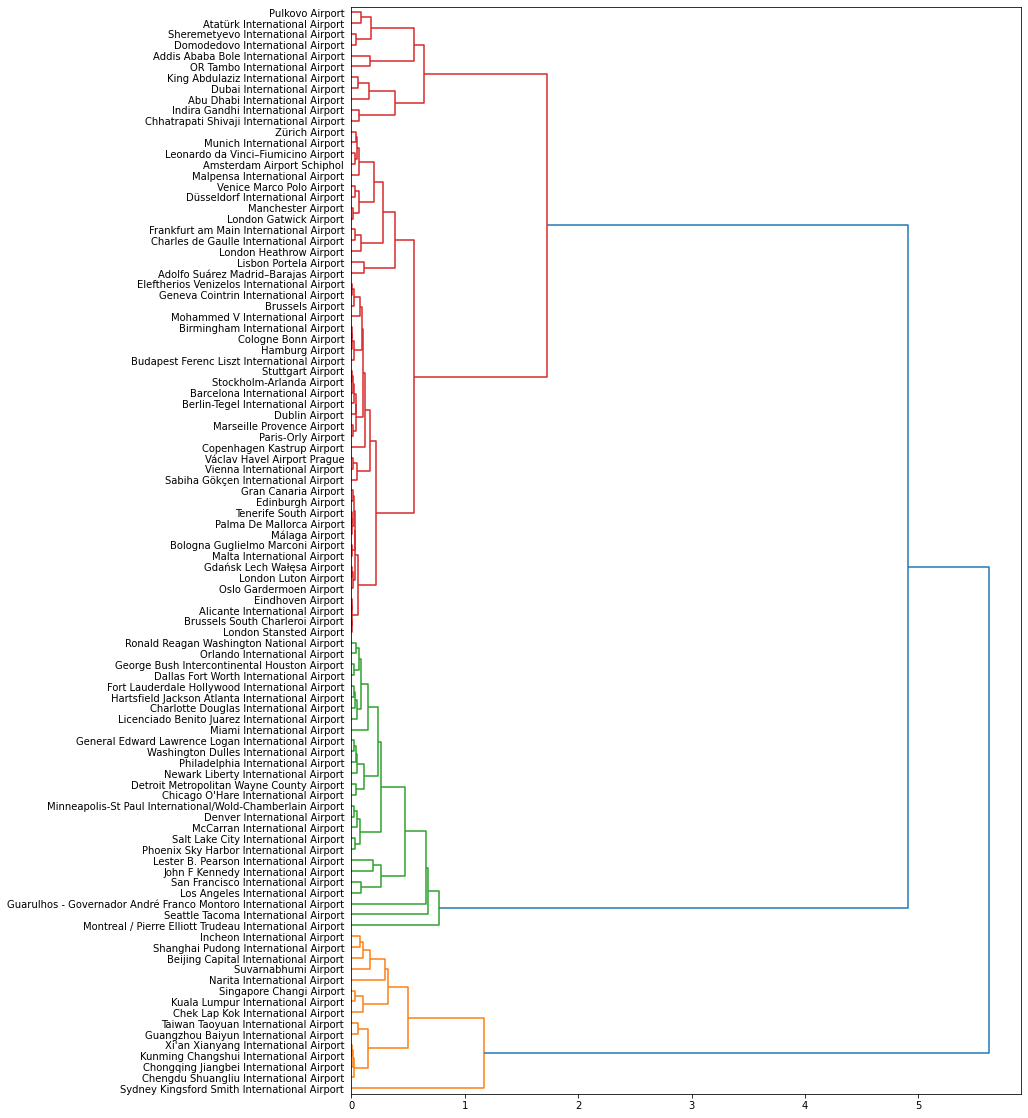

In [31]:
# Top 100 airports
n = len(names)
traffic = adjacency.dot(np.ones(n))
top_airports = np.argsort(-traffic)[:100]

Z = linkage(X[top_airports],method="ward")

fig = plt.figure(figsize=(12,20))
ax = fig.add_subplot()
leaves = dendrogram(Z,orientation="right",labels=names[top_airports],leaf_font_size=10)
plt.show()

## Wikipedia

In [32]:
graph = load_netset('wikivitals')

Parsing files...
Done.


In [33]:
adjacency = graph.adjacency
names = graph.names
labels = graph.labels

## To do

* Apply hierarchical clustering to the embedding in dimension 20.
* Select the 2 best clusterings and compare with the ground-truth in terms of ARI and AMI.
* Select the clustering with 20 clusters. List the top 3 articles of each cluster in terms of PageRank.
* Apply hierarchical clustering to the top-100 articles in terms of PageRank.
Display the dendrogram with the names of these articles.

In [34]:
gsvd = GSVD(n_components=20)
X = gsvd.fit_transform(adjacency)
Z = linkage(X, method="ward")

for best_cut in get_best_cuts(Z,len(Z))[:2]:
    y_pred = cut_tree(Z, best_cut).ravel()
    print("k =",best_cut)
    print("Metrics :")
    print(f"ARI : {round(adjusted_rand_score(labels,y_pred), 2)}, AMI : {round(adjusted_mutual_info_score(labels,y_pred), 2)}")

k = 2
Metrics :
ARI : 0.08, AMI : 0.24
k = 5
Metrics :
ARI : 0.29, AMI : 0.37


In [35]:
from sknetwork.ranking import PageRank, top_k

y_pred = cut_tree(Z, 20)

pagerank = PageRank(solver='lanczos')
scores = pagerank.fit_transform(adjacency)

for y_value in np.unique(y_pred):
    print("Cluster :",y_value)
    mask = (y_pred==y_value).ravel()
    print(names[mask][top_k(scores[mask], 3)])

Cluster : 0
['Mathematics' 'Real number' 'Geometry']
Cluster : 1
['Association football' 'Basketball' 'Olympic Games']
Cluster : 2
['United States' 'World War II' 'The New York Times']
Cluster : 3
['India' 'China' 'Japan']
Cluster : 4
['France' 'United Kingdom' 'Australia']
Cluster : 5
['Academy Awards' 'Orson Welles' 'Charlie Chaplin']
Cluster : 6
['Geographic coordinate system' 'Europe' 'Africa']
Cluster : 7
['Renaissance' 'Paris' 'Modernism']
Cluster : 8
['Earth' 'Astronomy' 'Sun']
Cluster : 9
['Aristotle' 'Age of Enlightenment' 'Plato']
Cluster : 10
['Latin' 'World War I' 'Greek language']
Cluster : 11
['Romanticism' 'Jazz' 'Johann Wolfgang von Goethe']
Cluster : 12
['BBC' 'Oxford English Dictionary' 'Internet']
Cluster : 13
['Mammal' 'Jurassic' 'Cambrian']
Cluster : 14
['World Health Organization' 'Tuberculosis' 'COVID-19 pandemic']
Cluster : 15
['Christianity' 'Islam' 'Catholic Church']
Cluster : 16
['Taxonomy (biology)' 'Animal' 'Protein']
Cluster : 17
['Physics' 'Albert Einstei

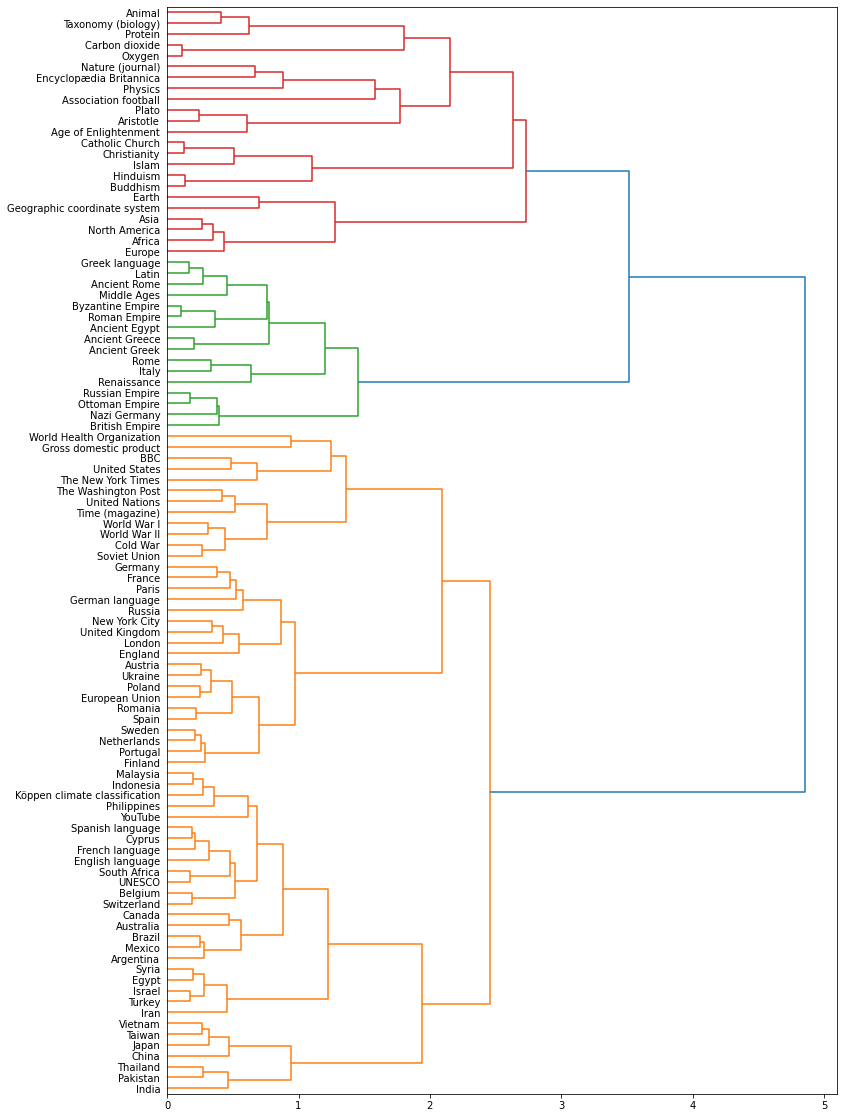

In [36]:
# Top 100 articles
mask = top_k(scores, 100)

Z = linkage(X[mask],method="ward")

fig = plt.figure(figsize=(12,20))
ax = fig.add_subplot()
leaves = dendrogram(Z,orientation="right",labels=names[mask],leaf_font_size=10)
plt.show()